Identify customers who churn the bank:

Preprocess the Banking dataset by removing unnecessary features, encoding categorical variables, and creating training and test splits. 

You can optinally keep this process minimal; we've seen a lot of practice already with Data Wrangling and Feature Engineering, already. 

However, do make sure to conduct the apropriate amount of EDA, given the dataset and time-constraints, as that may lead to insights into how you can structure your NN.

In [163]:
# Third party imports
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from typing import Tuple, Optional
import keras_tuner



from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight



In [164]:
df = pd.read_csv('banking_data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [165]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [166]:
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [168]:
df['Geography'].unique() # Since 3 categories, will be used One-Hot Encoding

array(['France', 'Spain', 'Germany'], dtype=object)

In [169]:
df['Geography'].value_counts()


Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [170]:
df1 = df.drop(['RowNumber','CustomerId','Surname'], axis=1).copy()


In [171]:
label = 'Exited'
features = ['CreditScore', 'Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']

In [172]:
training_df, testing_df = train_test_split(df1 , random_state=315)

In [173]:
feature_hot_encoded = OneHotEncoder(drop='first',sparse_output=False)
feature_hot_encoded.fit(training_df[['Geography']])

training_df['Geography'] = feature_hot_encoded.transform(training_df[['Geography']])
testing_df['Geography'] = feature_hot_encoded.transform(testing_df[['Geography']])



In [174]:
feature_hot_encoded = OneHotEncoder(drop='first',sparse_output=False)
feature_hot_encoded.fit(training_df[['Gender']])

training_df['Gender'] = feature_hot_encoded.transform(training_df[['Gender']])
testing_df['Gender'] = feature_hot_encoded.transform(testing_df[['Gender']])

In [175]:
feature_scaling = StandardScaler()
feature_scaling.fit(training_df[features])

training_df[features] = feature_scaling.transform(training_df[features])
testing_df[features] = feature_scaling.transform(testing_df[features])
training_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6850,-1.031420,-0.57735,0.913094,0.283616,-1.383537,-0.424634,-0.904700,0.63786,0.967204,-1.340670,0
5856,-1.433004,-0.57735,0.913094,-0.748601,0.345308,-1.232310,0.820949,0.63786,-1.033908,1.200270,0
2483,1.017685,-0.57735,0.913094,-0.185574,-0.691999,-1.232310,0.820949,0.63786,-1.033908,-1.455039,0
4915,0.605805,-0.57735,0.913094,0.565129,-1.383537,-1.232310,0.820949,0.63786,0.967204,-1.117250,0
4598,-0.135580,-0.57735,0.913094,0.658967,1.382615,1.018154,-0.904700,0.63786,-1.033908,-1.067983,0


Build and Compile a Sequential Artificial Neural Network using Keras with suitable activation functions, optimizer, and loss metrics for churn prediction. 

(NOTE: If you would like to experiment with hyper-parameter tuning check out KerasTuner)

Explain your choices for:

Activation Functions

Optimizers

Loss metrics

Network Structure / Architecture

In [176]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_df[label]),
    y=training_df[label]
)

class_weight_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weight_dict}')

Class weights: {0: 0.628456510809452, 1: 2.4461839530332683}


In [177]:
def make_callbacks(
    learning_rate: float,
    batch_size: int,
    patience: int = 10,
) -> Tuple[keras.callbacks.EarlyStopping, keras.callbacks.TensorBoard]:
    '''Create EarlyStopping and TensorBoard callbacks.'''

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=verbose
    )

    tensorboard_callback = keras.callbacks.TensorBoard(
        histogram_freq=1,
        write_graph=False
    )

    return early_stopping, tensorboard_callback

In [178]:
def build_model(hp) -> keras.Sequential:
    '''Builds and compiles the Keras Sequential model.'''

    lr = hp.Float(
        name="learning_rate",         # The learning rate is:(learning_rate=lr)
        min_value=1e-4,               # a step size in optimization
        max_value=1e-2,               # how fast or slow the model learns
        sampling="log"
        
    )

# activation function
#  the "sigmong" is used becasue target is classification

# Network Structure / Architecture --> Number of layers, Number of neurons per layer ,How information flows through the network
    model = keras.Sequential([
        layers.Input(shape=(10,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

# Optimizer controls how the model updates weights during training to minimize loss.
# Adam Optimizer

# The loss function measures how wrong the model’s predictions are.
# loss='binary_crossentropy' --> Designed for binary classification, Works with sigmoid output,Penalizes confident wrong predictions heavily

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr), # The optimizer only “sees” the loss
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [179]:
tuner = keras_tuner.RandomSearch( # KerasTuner compares models using " val_loss ", evaluation signal for tuner
    build_model,
    objective='val_loss', # Objective = model selection criterion, val_loss
                         #   How good the model is on unseen data“
                         #    When comparing different models, which number should I use to decide which one is better?”
    max_trials=5
    )

# FOR trial in range(max_trials):
#     1) Create a HyperParameters object (hp)
#     2) Randomly sample values for hp.Float, hp.Int, etc.
#     3) Call build_model(hp)
#     4) Train the model
#     5) Compute val_loss
#     6) Store results



Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:

# "tuner.search()" train the model like "fit()" does 
# which is "That call internally runs model.fit(...) for each trial."
# it call the model 
tuner.search(training_df[features],
             training_df[label],
             epochs=5,  
             validation_split=0.2,
             class_weights = class_weight_dict
             )
best_model = tuner.get_best_models(num_models=1)[0]





/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [190]:
# tuner.results_summary()


In [184]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)



{'learning_rate': 0.00036016488507721416}


In [186]:
y_prob = best_model.predict(X_test)
    

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
X_test = testing_df[features]
y_test = testing_df[label]

# Test performance (unseen data)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

In [187]:
thresholds = np.linspace(0.05, 0.95, 50)

results = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    
    # precision = precision_score(y_test, y_pred, zero_division=0)
    # recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Threshold is {t} and result is {f1}")  
    results.append((t, f1))
  

Threshold is 0.05 and result is 0.36504998148833767
Threshold is 0.06836734693877551 and result is 0.3918533604887984
Threshold is 0.08673469387755102 and result is 0.4222526219790242
Threshold is 0.10510204081632653 and result is 0.4502776375567895
Threshold is 0.12346938775510204 and result is 0.47429519071310117
Threshold is 0.14183673469387753 and result is 0.4949193066347878
Threshold is 0.16020408163265304 and result is 0.5185185185185185
Threshold is 0.17857142857142855 and result is 0.5372522214627478
Threshold is 0.19693877551020406 and result is 0.5553145336225597
Threshold is 0.21530612244897956 and result is 0.558530986993114
Threshold is 0.23367346938775507 and result is 0.5682182985553772
Threshold is 0.2520408163265306 and result is 0.5723849372384937
Threshold is 0.2704081632653061 and result is 0.577391304347826
Threshold is 0.2887755102040816 and result is 0.5737556561085972
Threshold is 0.3071428571428571 and result is 0.5638599810785241
Threshold is 0.32551020408163

In [ ]:
# df_thresh = pd.DataFrame(
#     results, columns=["threshold", "f1"]
# )
# df_thresh.sort_values("f1", ascending=False).head()

In [188]:
y_pred = (y_prob >= 0.27).astype(int)    

Train and Evaluate the model using suitable metrics to measure performance.

For your trained Neural Network Create and Describe

Confusion Matrix

AUC-ROC Curves

Precision-Recall Curves

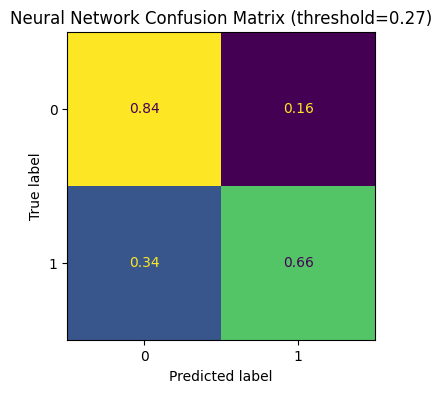

In [189]:

fig, ax = plt.subplots(figsize=(5, 4))

ax.set_title("Neural Network Confusion Matrix (threshold=0.27)")


disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize='true',
    ax=ax,
    colorbar=False
)